In [2]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [5]:
# function for cross correlation
def cross_correlation(image, kernel, k): # the input image is padded
    new_img = np.zeros((image.shape[0] - 2*k,image.shape[1] - 2*k))
    for i in range(image.shape[0] - 2*k):
        for j in range(image.shape[1] - 2*k):
            new_img[i, j] = np.sum(image[i:i+ 2*k + 1, j:j+ 2*k + 1]*kernel) # cross_correlation
    return new_img

In [6]:
# functions for preprocess the image for question 1 and 3, the codes are borrowed form the lecture
def window_image(img, window_center,window_width, intercept, slope, rescale=True):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    if rescale:
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
    
    return img
    
def get_pixels_hu(image_path, rescale=True): ## Just using hu values
        dicom = pydicom.read_file(image_path)
        image = dicom.pixel_array.astype(np.int16)

    # The intercept is usually -1024, so air is approximately 0
         
    # Convert to Hounsfield units (HU)
        intercept = dicom.RescaleIntercept
        slope = dicom.RescaleSlope
    
        if slope != 1:
            image = slope * image.astype(np.float64)
            image = image.astype(np.int16)
        
        image += np.int16(intercept)
    
        image[image < -1024] = -1024 # Setting values smaller than air, to air .
        if rescale:
        # Extra rescaling to 0-1
            image = (image - 0) / (max(max(image))- 0)
        return np.array(image, dtype=np.int16)
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)      
    
def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

def img_crop(img):
    thresholded = cv2.threshold(img.astype('uint8'),0,255,cv2.THRESH_OTSU)
    bbox = cv2.boundingRect(thresholded[1])
    x, y, w, h = bbox
    foreground = img[y:y+h, x:x+w]
    return foreground

def preprocess(dcm):    
    window_center , window_width, intercept, slope = get_windowing(dcm)
    img = dcm.pixel_array
    img = window_image(img, window_center, window_width, intercept, slope)
    img = img_crop(img)
    resized = cv2.resize(img, (224, 224))
    return resized

### Show results

In [9]:
#read and preprocess image for problem 1 and 3
dcm = pydicom.dcmread('./ID_0002a616e.dcm')
image = preprocess(dcm)

Text(0.5, 1.0, 'Sharpened image')

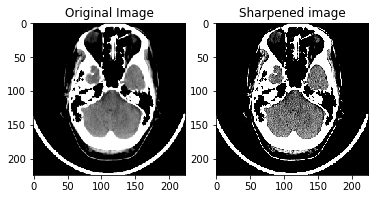

In [10]:
# problem 1
sharpen_kernel = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]])
k = 1
pad_image = np.pad(image,(k,k),'edge') # padding with the values of the edges
new_img = cross_correlation(pad_image, sharpen_kernel, k)
# bound the value to 0-1
new_img[new_img < 0] = 0
new_img[new_img > 1] = 1

# plt.imshow(new_img, cmap=plt.cm.gray)
plt.subplot(121),plt.imshow(image,cmap = 'gray')
plt.title('Original Image')
plt.subplot(122),plt.imshow(new_img,cmap = 'gray')
plt.title('Sharpened image')

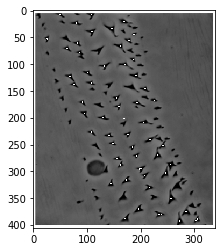

In [16]:
#Problem 2
ori_img = cv2.imread('./original image.png',0)
img = cv2.imread('./original image.png',0)
template = cv2.imread('./template.png',0)
size = 3
resized = cv2.resize(template,(size,size)) # resize the template
img_padded = np.pad(img,(k,k),'edge') # padding
res = cross_correlation(img_padded, resized, k)
# noramlize the result image
gap = (np.max(res) - np.min(res))
res =  (res - np.min(res))/gap

# find the areas that has connectivity of at leat 8 and the value is less than a threshold
threshold = 0.2
binary_map = (res < threshold).astype(np.uint8)
connectivity = 8
areas = cv2.connectedComponentsWithStats(binary_map, connectivity, cv2.CV_32S)
centroids = areas[3] #centroids of the areas
for pt in centroids: 
    pt = tuple([int(pt[0]), int(pt[1])])
    cv2.rectangle(img, pt, (pt[0], pt[1]), (255, 0, 0), 2) # show the matched template

plt.imshow(img,cmap = 'gray')



Text(0.5, 1.0, 'Edge detection')

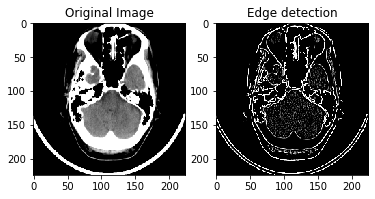

In [15]:
# problem 3
edge_dection_kernel = np.array([[-1, -1, -1],[-1, 8, -1],[-1, -1, -1]])
k = 1
pad_image = np.pad(image,(k,k),'edge')
# flip the kernel for convolution
edge_dection_kernel = np.flip(np.flip(edge_dection_kernel,1), 0) 
new_img1 = cross_correlation(pad_image, edge_dection_kernel, k)
# bound the value to 0-1
new_img1[new_img1 < 0] = 0
new_img1[new_img1 > 1] = 1
# plt.imshow(new_img1, cmap=plt.cm.gray)
plt.subplot(121),plt.imshow(image,cmap = 'gray')
plt.title('Original Image')
plt.subplot(122),plt.imshow(new_img1,cmap = 'gray')
plt.title('Edge detection')